<h1 align=center><font size = 5>Lab - Segmenting and Clustering Neighborhoods in Toronto</font></h1>

## Introduction

Required to explore, segment, and cluster the neighborhoods in the city of Toronto. For the Toronto neighborhood data, a Wikipedia page exists that has all the information we need to explore and cluster the neighborhoods in Toronto. You will be required to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe. Once the data is in a structured format, required to replicate the analysis dataset to explore and cluster the neighborhoods in the city of Toronto.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Prepare Dataset</a>

2. <a href="#item2">Supplement Dataset</a>

3. <a href="#item3">Explore and cluster the neighborhoods in Toronto</a>

4. <a href="#item5">Examine Clusters</a>    
</font>
</div>

In [5]:
import requests 
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import json
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c anaconda beautifulsoup4 --yes
from bs4 import BeautifulSoup

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    numpy-1.18.1               |   py36h95a1406_0         5.2 MB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    scipy-1.4.1                |   py36h921218d_0        18.9 MB  conda-forge


## 1. Download and Prepare Dataset
First we making request to wikipedia and scrape all the html code. From the html code, we take the text of tag "th" and "td", for columns headers and content of future dataframe. After  that we create a pandas dataframe.

### Scrape Wikipedia and parse the data by using BeautifulSoup

In [6]:
# Make request to wiki to scrape all the html code
response = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(response.text, 'html.parser')

In [7]:
# Get list of headers
th_tag = soup.find_all("th")
headers = []

for th in th_tag[:3]:
    head = th.get_text().strip('\n')
    headers.append(head)

In [8]:
# Get lists of columns
tbody_tag = soup.tbody.find_all("td")

col_1 = []
col_2 = []
col_3 = []
i = 0

for td in tbody_tag:
    td_data = td.get_text().strip('\n')
    if i == 0:
        col_1.append(td_data)
        i += 1
    elif i == 1:
        col_2.append(td_data)
        i += 1
    else:
        col_3.append(td_data)
        i = 0

### Create Dataframe

In [9]:
result = {headers[0]: col_1, headers[1]: col_2, headers[2]: col_3}
toronto_df = pd.DataFrame(result)
toronto_df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### Prepare Dataframe

Ignore cells with a borough that is Not assigned. If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

In [10]:
# Remove "Not assigned borough"
indexNames = toronto_df[toronto_df["Borough"] == "Not assigned"].index
toronto_df.drop(indexNames, axis=0, inplace=True)
toronto_df.reset_index(inplace=True, drop=True)

# Replace "Not assigned" by "Borough".
toronto_df['Neighborhood'] = toronto_df['Neighbourhood'].replace('Not assigned', toronto_df['Borough'])
toronto_df.drop(['Neighbourhood'], axis=1, inplace=True)
toronto_df.head()

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


## 2. Supplement Dataset

Now we have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

### Get the latitude and the longitude coordinates

For this purpose we use before prepared csv file.

In [11]:
# Read the csv file and make dataframe of coordinates

coord_df = pd.read_csv("Geospatial_Coordinates.csv")
coord_df.rename(columns={"Postal Code": "Postcode"}, inplace=True)

In [12]:
# Merge two dataframes

toronto_data = pd.merge(toronto_df, 
                  coord_df[['Postcode','Latitude', 'Longitude']], 
                  on='Postcode')
toronto_data.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Heights,43.718518,-79.464763
4,M6A,North York,Lawrence Manor,43.718518,-79.464763


### Create map of the Toronto with all neighborhoods

In [13]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [14]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## 3. Explore and cluster the neighborhoods in Toronto
For better representation we will be explore the **Etobicoke** borough. First we create dataframe of borough. Second we get all venue categories of each neighborhood by utilize Foursquare API. Then we will use pandas methods to explore the result.

In [15]:
# Create dataframe contains only neighborhoods of Etobicoke
etobicoke_data = toronto_data[toronto_data['Borough'] == 'Etobicoke'].reset_index(drop=True)
etobicoke_data

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
1,M9B,Etobicoke,Cloverdale,43.650943,-79.554724
2,M9B,Etobicoke,Islington,43.650943,-79.554724
3,M9B,Etobicoke,Martin Grove,43.650943,-79.554724
4,M9B,Etobicoke,Princess Gardens,43.650943,-79.554724
5,M9B,Etobicoke,West Deane Park,43.650943,-79.554724
6,M9C,Etobicoke,Bloordale Gardens,43.643515,-79.577201
7,M9C,Etobicoke,Eringate,43.643515,-79.577201
8,M9C,Etobicoke,Markland Wood,43.643515,-79.577201
9,M9C,Etobicoke,Old Burnhamthorpe,43.643515,-79.577201


### Create map of the Etobickoke Neighborhoods 

In [16]:
address = 'Etobicoke, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Etobicoke are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Etobicoke are 43.671459150000004, -79.55249206611668.


In [17]:
# create map of Manhattan using latitude and longitude values
map_etobicoke = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(etobicoke_data['Latitude'], etobicoke_data['Longitude'], etobicoke_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_etobicoke)  
    
map_etobicoke

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [18]:
CLIENT_ID = 'FJV5ILBCCU4MYGEJXN0DES4BLH20LO5054SN2OVZ3MLBVQZA' 
CLIENT_SECRET = 'OAKPQMD0YBXOHGQWATGE045MTNZDJ2AUBH2ACSBDPL4TN2AL'
VERSION = '20180605'

Get the first neighborhood's latitude and longitude values.

In [19]:
#First neighborhood
neighborhood_latitude = etobicoke_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = etobicoke_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = etobicoke_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Islington Avenue are 43.6678556, -79.53224240000002.


#### Now, let's get the top 100 venues that are in each neighborhoods within a radius of 500 meters in Etobicoke.

In [20]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

Function make request to Foresquare and GET vanues 

In [21]:
def get_nearby_venues(names, latitudes, longitudes, radius=500):
    
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *etobicoke_venues*

In [22]:
etobicoke_venues = get_nearby_venues(names=etobicoke_data['Neighborhood'],
                                   latitudes=etobicoke_data['Latitude'],
                                   longitudes=etobicoke_data['Longitude']
                                  )

Islington Avenue
Cloverdale
Islington
Martin Grove
Princess Gardens
West Deane Park
Bloordale Gardens
Eringate
Markland Wood
Old Burnhamthorpe
Westmount
Kingsview Village
Martin Grove Gardens
Richview Gardens
St. Phillips
Humber Bay Shores
Mimico South
New Toronto
Albion Gardens
Beaumond Heights
Humbergate
Jamestown
Mount Olive
Silverstone
South Steeles
Thistletown
Alderwood
Long Branch
Northwest
The Kingsway
Montgomery Road
Old Mill North
Humber Bay
King's Mill Park
Kingsway Park South East
Mimico NE
Old Mill South
The Queensway East
Royal York South East
Sunnylea
Kingsway Park South West
Mimico NW
The Queensway West
Royal York South West
South of Bloor


#### Let's check the size of the resulting dataframe

In [23]:
print(etobicoke_venues.shape)
etobicoke_venues.head()

(275, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bloordale Gardens,43.643515,-79.577201,LCBO,43.642099,-79.576592,Liquor Store
1,Bloordale Gardens,43.643515,-79.577201,Starbucks,43.641312,-79.576924,Coffee Shop
2,Bloordale Gardens,43.643515,-79.577201,The Beer Store,43.641313,-79.576925,Beer Store
3,Bloordale Gardens,43.643515,-79.577201,Shoppers Drug Mart,43.641312,-79.576924,Cosmetics Shop
4,Bloordale Gardens,43.643515,-79.577201,Pizza Hut,43.641845,-79.576556,Pizza Place


#### Let's check how many venues were returned for each neighborhood

In [24]:
etobicoke_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Albion Gardens,10,10,10,10,10,10
Alderwood,9,9,9,9,9,9
Beaumond Heights,10,10,10,10,10,10
Bloordale Gardens,9,9,9,9,9,9
Eringate,9,9,9,9,9,9
Humber Bay,1,1,1,1,1,1
Humber Bay Shores,10,10,10,10,10,10
Humbergate,10,10,10,10,10,10
Jamestown,10,10,10,10,10,10


#### Let's find out how many unique categories can be curated from all the returned venues

In [25]:
print('There are {} uniques categories.'.format(len(etobicoke_venues['Venue Category'].unique())))

There are 39 uniques categories.


## Explore Each Neighborhood

In [26]:
# one hot encoding
etobicoke_onehot = pd.get_dummies(etobicoke_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
etobicoke_onehot['Neighborhood'] = etobicoke_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [etobicoke_onehot.columns[-1]] + list(etobicoke_onehot.columns[:-1])
etobicoke_onehot = etobicoke_onehot[fixed_columns]

etobicoke_onehot.head()

,Neighborhood,Bakery,Baseball Field,Beer Store,Burger Joint,Burrito Place,Bus Line,Café,Chinese Restaurant,Coffee Shop,Convenience Store,Cosmetics Shop,Discount Store,Drugstore,Fast Food Restaurant,Fried Chicken Joint,Grocery Store,Gym,Hardware Store,Intersection,Japanese Restaurant,Liquor Store,Middle Eastern Restaurant,Mobile Phone Shop,Park,Pet Store,Pharmacy,Pizza Place,Pool,Pub,Rental Car Location,Restaurant,River,Sandwich Place,Skating Rink,Smoke Shop,Supplement Shop,Tanning Salon,Thrift / Vintage Store,Wings Joint
0,Bloordale Gardens,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bloordale Gardens,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bloordale Gardens,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bloordale Gardens,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Bloordale Gardens,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


#### Let's examine the new dataframe size.

In [27]:
etobicoke_onehot.shape

(275, 40)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [28]:
etobicoke_grouped = etobicoke_onehot.groupby('Neighborhood').mean().reset_index()
etobicoke_grouped.head()

,Neighborhood,Bakery,Baseball Field,Beer Store,Burger Joint,Burrito Place,Bus Line,Café,Chinese Restaurant,Coffee Shop,Convenience Store,Cosmetics Shop,Discount Store,Drugstore,Fast Food Restaurant,Fried Chicken Joint,Grocery Store,Gym,Hardware Store,Intersection,Japanese Restaurant,Liquor Store,Middle Eastern Restaurant,Mobile Phone Shop,Park,Pet Store,Pharmacy,Pizza Place,Pool,Pub,Rental Car Location,Restaurant,River,Sandwich Place,Skating Rink,Smoke Shop,Supplement Shop,Tanning Salon,Thrift / Vintage Store,Wings Joint
0,Albion Gardens,0.0,0.0,0.100000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.1,0.0,0.1,0.1,0.2,0.000000,0.0,0.0,0.1,0.000000,0.0,0.0,0.000000,0.000000,0.100000,0.100000,0.000000,0.000000,0.0,0.0,0.0,0.100000,0.000000,0.0,0.0,0.0,0.0,0.0
1,Alderwood,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.111111,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.111111,0.222222,0.111111,0.111111,0.0,0.0,0.0,0.111111,0.111111,0.0,0.0,0.0,0.0,0.0
2,Beaumond Heights,0.0,0.0,0.100000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.1,0.0,0.1,0.1,0.2,0.000000,0.0,0.0,0.1,0.000000,0.0,0.0,0.000000,0.000000,0.100000,0.100000,0.000000,0.000000,0.0,0.0,0.0,0.100000,0.000000,0.0,0.0,0.0,0.0,0.0
3,Bloordale Gardens,0.0,0.0,0.111111,0.0,0.0,0.0,0.111111,0.0,0.111111,0.111111,0.111111,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.111111,0.0,0.0,0.111111,0.111111,0.000000,0.111111,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,Eringate,0.0,0.0,0.111111,0.0,0.0,0.0,0.111111,0.0,0.111111,0.111111,0.111111,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.111111,0.0,0.0,0.111111,0.111111,0.000000,0.111111,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


#### Let's confirm the new size

In [29]:
etobicoke_grouped.shape

(39, 40)

#### Let's print each neighborhood along with the top 5 most popular venues

In [30]:
num_top_venues = 5

for hood in etobicoke_grouped['Neighborhood']:
    print("----"+ hood +"----")
    temp = etobicoke_grouped[etobicoke_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Albion Gardens----
                 venue  freq
0        Grocery Store   0.2
1  Japanese Restaurant   0.1
2       Sandwich Place   0.1
3             Pharmacy   0.1
4          Pizza Place   0.1


----Alderwood----
          venue  freq
0   Pizza Place  0.22
1           Pub  0.11
2           Gym  0.11
3      Pharmacy  0.11
4  Skating Rink  0.11


----Beaumond Heights----
                 venue  freq
0        Grocery Store   0.2
1  Japanese Restaurant   0.1
2       Sandwich Place   0.1
3             Pharmacy   0.1
4          Pizza Place   0.1


----Bloordale Gardens----
          venue  freq
0     Pet Store  0.11
1    Beer Store  0.11
2  Liquor Store  0.11
3   Pizza Place  0.11
4          Café  0.11


----Eringate----
          venue  freq
0     Pet Store  0.11
1    Beer Store  0.11
2  Liquor Store  0.11
3   Pizza Place  0.11
4          Café  0.11


----Humber Bay----
                       venue  freq
0             Baseball Field   1.0
1               Liquor Store   0.0
2  Middle Eas

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = etobicoke_grouped['Neighborhood']

for ind in np.arange(etobicoke_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(etobicoke_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albion Gardens,Grocery Store,Japanese Restaurant,Pizza Place,Beer Store,Fried Chicken Joint,Fast Food Restaurant,Sandwich Place,Discount Store,Pharmacy,Drugstore
1,Alderwood,Pizza Place,Pool,Sandwich Place,Coffee Shop,Pharmacy,Pub,Gym,Skating Rink,Burrito Place,Bus Line
2,Beaumond Heights,Grocery Store,Japanese Restaurant,Pizza Place,Beer Store,Fried Chicken Joint,Fast Food Restaurant,Sandwich Place,Discount Store,Pharmacy,Drugstore
3,Bloordale Gardens,Convenience Store,Beer Store,Liquor Store,Café,Park,Coffee Shop,Pet Store,Cosmetics Shop,Pizza Place,Discount Store
4,Eringate,Convenience Store,Beer Store,Liquor Store,Café,Park,Coffee Shop,Pet Store,Cosmetics Shop,Pizza Place,Discount Store


## Cluster Neighborhoods

#### Let's find out what number of cluster will give us better result

In [33]:
etobicoke_grouped_clustering = etobicoke_grouped.drop('Neighborhood', 1)

In [35]:
Ks = 10 # number of ks we will test
inertias = np.zeros((Ks-1))
for n in range(1,Ks):
    
    # run k-means clustering
    kmeans = KMeans(n_clusters=n, random_state=0, n_init = 12).fit(etobicoke_grouped_clustering)
    inertias[n-1] = kmeans.inertia_

# display the inertia    
inertias

array([10.29945643,  3.6670945 ,  2.6631872 ,  1.91554086,  1.39013573,
        0.97521634,  0.62724691,  0.27613169,  0.10288066])

#### Plot the inertia with the different k to find the better balance

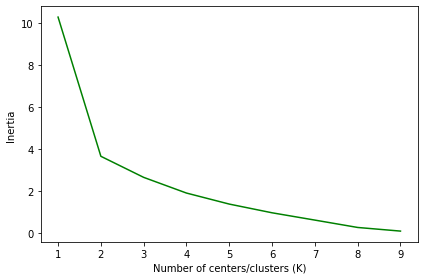

In [36]:
plt.plot(range(1,Ks),inertias,'g')
plt.ylabel('Inertia ')
plt.xlabel('Number of centers/clusters (K)')
plt.tight_layout()
plt.show()

Better result we will get on 4 clusters. 

Run *k*-means to cluster the neighborhood into 4 clusters.

In [37]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(etobicoke_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [38]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

etobicoke_merged = etobicoke_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
etobicoke_merged = etobicoke_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how='right')

etobicoke_merged.head() # check the last columns!

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,M9C,Etobicoke,Bloordale Gardens,43.643515,-79.577201,0,Convenience Store,Beer Store,Liquor Store,Café,Park,Coffee Shop,Pet Store,Cosmetics Shop,Pizza Place,Discount Store
7,M9C,Etobicoke,Eringate,43.643515,-79.577201,0,Convenience Store,Beer Store,Liquor Store,Café,Park,Coffee Shop,Pet Store,Cosmetics Shop,Pizza Place,Discount Store
8,M9C,Etobicoke,Markland Wood,43.643515,-79.577201,0,Convenience Store,Beer Store,Liquor Store,Café,Park,Coffee Shop,Pet Store,Cosmetics Shop,Pizza Place,Discount Store
9,M9C,Etobicoke,Old Burnhamthorpe,43.643515,-79.577201,0,Convenience Store,Beer Store,Liquor Store,Café,Park,Coffee Shop,Pet Store,Cosmetics Shop,Pizza Place,Discount Store
10,M9P,Etobicoke,Westmount,43.696319,-79.532242,0,Coffee Shop,Sandwich Place,Middle Eastern Restaurant,Pizza Place,Chinese Restaurant,Intersection,Burrito Place,Bus Line,Café,Burger Joint


In [39]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(etobicoke_merged['Latitude'], etobicoke_merged['Longitude'], etobicoke_merged['Neighborhood'], etobicoke_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 4. Examine Clusters 

#### Cluster #1

In [40]:
etobicoke_merged.loc[etobicoke_merged['Cluster Labels'] == 0, etobicoke_merged.columns[[2] + list(range(5, etobicoke_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Bloordale Gardens,0,Convenience Store,Beer Store,Liquor Store,Café,Park,Coffee Shop,Pet Store,Cosmetics Shop,Pizza Place,Discount Store
7,Eringate,0,Convenience Store,Beer Store,Liquor Store,Café,Park,Coffee Shop,Pet Store,Cosmetics Shop,Pizza Place,Discount Store
8,Markland Wood,0,Convenience Store,Beer Store,Liquor Store,Café,Park,Coffee Shop,Pet Store,Cosmetics Shop,Pizza Place,Discount Store
9,Old Burnhamthorpe,0,Convenience Store,Beer Store,Liquor Store,Café,Park,Coffee Shop,Pet Store,Cosmetics Shop,Pizza Place,Discount Store
10,Westmount,0,Coffee Shop,Sandwich Place,Middle Eastern Restaurant,Pizza Place,Chinese Restaurant,Intersection,Burrito Place,Bus Line,Café,Burger Joint
15,Humber Bay Shores,0,Bakery,Restaurant,Fried Chicken Joint,Liquor Store,Fast Food Restaurant,Pharmacy,Pizza Place,Gym,Coffee Shop,Café
16,Mimico South,0,Bakery,Restaurant,Fried Chicken Joint,Liquor Store,Fast Food Restaurant,Pharmacy,Pizza Place,Gym,Coffee Shop,Café
17,New Toronto,0,Bakery,Restaurant,Fried Chicken Joint,Liquor Store,Fast Food Restaurant,Pharmacy,Pizza Place,Gym,Coffee Shop,Café
18,Albion Gardens,0,Grocery Store,Japanese Restaurant,Pizza Place,Beer Store,Fried Chicken Joint,Fast Food Restaurant,Sandwich Place,Discount Store,Pharmacy,Drugstore
19,Beaumond Heights,0,Grocery Store,Japanese Restaurant,Pizza Place,Beer Store,Fried Chicken Joint,Fast Food Restaurant,Sandwich Place,Discount Store,Pharmacy,Drugstore


#### Cluster #2

In [41]:
etobicoke_merged.loc[etobicoke_merged['Cluster Labels'] == 1, etobicoke_merged.columns[[2] + list(range(5, etobicoke_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Humber Bay,1,Baseball Field,Wings Joint,Convenience Store,Gym,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Drugstore,Discount Store,Cosmetics Shop
33,King's Mill Park,1,Baseball Field,Wings Joint,Convenience Store,Gym,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Drugstore,Discount Store,Cosmetics Shop
34,Kingsway Park South East,1,Baseball Field,Wings Joint,Convenience Store,Gym,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Drugstore,Discount Store,Cosmetics Shop
35,Mimico NE,1,Baseball Field,Wings Joint,Convenience Store,Gym,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Drugstore,Discount Store,Cosmetics Shop
36,Old Mill South,1,Baseball Field,Wings Joint,Convenience Store,Gym,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Drugstore,Discount Store,Cosmetics Shop
37,The Queensway East,1,Baseball Field,Wings Joint,Convenience Store,Gym,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Drugstore,Discount Store,Cosmetics Shop
38,Royal York South East,1,Baseball Field,Wings Joint,Convenience Store,Gym,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Drugstore,Discount Store,Cosmetics Shop
39,Sunnylea,1,Baseball Field,Wings Joint,Convenience Store,Gym,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Drugstore,Discount Store,Cosmetics Shop


#### Cluster #3

In [42]:
etobicoke_merged.loc[etobicoke_merged['Cluster Labels'] == 2, etobicoke_merged.columns[[2] + list(range(5, etobicoke_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,The Kingsway,2,Smoke Shop,River,Park,Wings Joint,Convenience Store,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Drugstore,Discount Store
30,Montgomery Road,2,Smoke Shop,River,Park,Wings Joint,Convenience Store,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Drugstore,Discount Store
31,Old Mill North,2,Smoke Shop,River,Park,Wings Joint,Convenience Store,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Drugstore,Discount Store


#### Cluster #4

In [43]:
etobicoke_merged.loc[etobicoke_merged['Cluster Labels'] == 3, etobicoke_merged.columns[[2] + list(range(5, etobicoke_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Kingsview Village,3,Pizza Place,Mobile Phone Shop,Sandwich Place,Bus Line,Wings Joint,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Drugstore,Discount Store
12,Martin Grove Gardens,3,Pizza Place,Mobile Phone Shop,Sandwich Place,Bus Line,Wings Joint,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Drugstore,Discount Store
13,Richview Gardens,3,Pizza Place,Mobile Phone Shop,Sandwich Place,Bus Line,Wings Joint,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Drugstore,Discount Store
14,St. Phillips,3,Pizza Place,Mobile Phone Shop,Sandwich Place,Bus Line,Wings Joint,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Drugstore,Discount Store
